- `python -m venv .venv`
- `.venv\Scripts\Activate.ps1`
- `python.exe -m pip install --upgrade pip`
- `pip install matplotlib numpy tensorflow scikit-learn mlflow`
- `mlflow ui` 

train_linear_regression a pris 0.0062 secondes
evaluate_linear_regression a pris 0.0012 secondes


c:\GITHUB\python-utils\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


train_neural_network a pris 8.6651 secondes
evaluate_neural_network a pris 0.0670 secondes


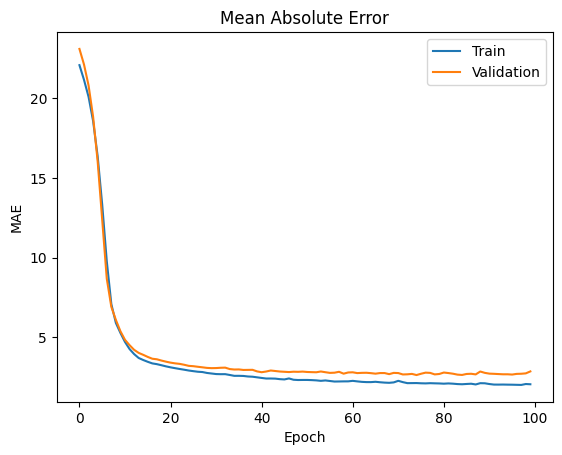

2024/12/19 10:46:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/19 10:46:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/19 10:46:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import mlflow
import time
from functools import wraps

# Décorateur pour mesurer le temps d'exécution
def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        debut = time.perf_counter()
        resultat = func(*args, **kwargs)
        fin = time.perf_counter()
        duree = fin - debut
        print(f"{func.__name__} a pris {duree:.4f} secondes")
        return resultat
    return wrapper

# Charger les données Boston Housing
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data()

# Normaliser les données
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# Démarrer une expérience MLflow
with mlflow.start_run():

    # Entraîner et évaluer la régression linéaire
    @timer
    def train_linear_regression(x_train, y_train):
        model = LinearRegression()
        model.fit(x_train, y_train)
        return model
    @timer
    def evaluate_linear_regression(model, x_test, y_test):
        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        return r2, mae, mse   

    model_LinReg = train_linear_regression(x_train, y_train)
    r2, mae, mse = evaluate_linear_regression(model_LinReg, x_test, y_test)
    mlflow.log_metric("r2_linear", r2)
    mlflow.log_metric("mae_linear", mae)
    mlflow.log_metric("mse_linear", mse)

    # Entraîner et évaluer le réseau de neurones
    @timer
    def train_neural_network(x_train, x_test, y_train, y_test):
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2)
        return history, model
    
    @timer
    def evaluate_neural_network(model, x_test, y_test):
        _, mae = model.evaluate(x_test, y_test, verbose=0)
        return mae    

    history, model_keras = train_neural_network(x_train, x_test, y_train, y_test)
    mae_nn = evaluate_neural_network(model_keras, x_test, y_test)
    mlflow.log_metric("mae_nn", mae_nn)

    # Afficher l'historique de l'entraînement
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Enregistrer le modèle avec MLflow
    mlflow.sklearn.log_model(model_LinReg, "model_Linear_Regression")
    mlflow.keras.log_model(model_keras, "model_keras")

# dans la console 
`mlflow ui`